In [1]:
# analyze the state increment from DA in FV3
# calculate the mean increment over several DA cycles
# initial built: 05/10/2024
# add U,V increment: 10/10/2024


In [1]:
from datetime import datetime, timedelta
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
print(cartopy.__version__)
import pickle


0.21.1


In [19]:
datahome  = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/state_space_diag/state_space_inc/'

expid_dic = {'CTRL'        : 'new_ctrl_amsua_atms', \
             'CTRL_no_situ': 'new_ctrl_amsua_atms_no_situ_only_scatter_wind', \
             'ng_all_infla': 'shield_ensreplay_ng_all_situ_oberr_infla', \
             'ng_v0'       : 'shield_ensreplay_ng_only_scatter_wind_v0',  \
             'ctrl'        : 'ctrl', \
             'ctrl_noinf'  : 'ctrl_noinf', \
             'only_clr_clr': 'only_clr_clr', \
             'only_clr_clr_noinf': 'only_clr_clr_noinf', \
             'clr_and_cld' : 'clr_clr_and_cld_cld_0.05', \
             'clr_and_cld_noinf': 'clr_clr_and_cld_cld_0.05_noinf', \
             'clr_and_cld_sym': 'clr_clr_and_cld_cld_0.05_varbcpred_sym_cld', \
             'clr_and_cld_obs': 'clr_clr_and_cld_cld_0.05_varbcpred_obs_cld', \
             'clr_and_cld_obs_noinf': 'clr_clr_and_cld_cld_0.05_varbcpred_obs_cld_noinf', \
             'clr_and_cld_model': 'clr_clr_and_cld_cld_0.05_varbcpred_model_cld', \
             'full_CTRL' : 'full_CTRL', \
             'full_only_clr': 'full_only_clr_clr', \
             'full_clr_cld': 'full_clr_clr_and_cld_cld_0.05', \
             'full_all' : 'full_ctrl', \
             'full_CTRL_noinf': 'full_CTRL_noinf', \
             'full_all_noinf': 'full_ctrl_noinf', \
             'full_sym': 'full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_nobc', \
             'full_obs': 'full_clr_clr_and_cld_cld_0.05_varbcpred_obs_cld', \
             'full_model': 'full_clr_clr_and_cld_cld_0.05_varbcpred_model_cld_nobc', \
             'full_sym_clwnbc': 'full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_clwnbc', \
             'full_sym_tri_clwnbc': 'full_clr_clr_and_cld_cld_0.05_varbcpred_sym_cld_tri_clwnbc' }

#expids    = ['ctrl','ctrl_noinf','only_clr_clr','clr_and_cld','clr_and_cld_sym','clr_and_cld_obs','clr_and_cld_model']
'''
expids = ['ctrl', 'ctrl_noinf', \
          'only_clr_clr', 'only_clr_clr_noinf', \
          'clr_and_cld', 'clr_and_cld_noinf', \
          'clr_and_cld_obs', 'clr_and_cld_obs_noinf']
'''

#expids = ['full_CTRL','full_CTRL_noinf', 'full_sym_clwnbc']
expids = ['full_clr_cld', 'full_sym_clwnbc', 'full_sym_tri_clwnbc']

init_time  = datetime(2022, 6, 15, 0, 0, 0)  # Year, month, day, hour, minute, second
final_time = datetime(2022, 8, 10, 0, 0, 0)  # Year, month, day, hour, minute, second
skip_time  = datetime(2022, 6, 25, 0, 0, 0)
dt         = 24 # in hours

In [20]:
read_precalculated_data = True

In [21]:
if read_precalculated_data:
    
    T={}; HUM={}; LW={}; ICMR={}; U={}; V={};

    for e, exp in enumerate(expids):
        filename  = f'mean_analysis_increment_{exp}'
        pkl_fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/state_space_diag/pkl_data/{filename}.pkl'

        # Open the file in binary read mode
        with open(pkl_fn, 'rb') as file:
            data = pickle.load(file)
            
            T[exp]   = data['T']
            HUM[exp] = data['HUM']
            U[exp]   = data['U']
            V[exp]   = data['V']
            
            if e==0:
                lat = data['lat']
                lon = data['lon']
                lev = data['lev']
                
else: # calculate the monthly mean analysis increment from .nc files (it takes time)
    
    T={}; HUM={}; LW={}; ICMR={}; U={}; V={};
    for exp in expids:

        current_time = init_time
        n_files=0  # how many files are averaged

        while current_time <= final_time:
            
            if current_time == skip_time:
                current_time = current_time + timedelta(hours=dt)
                continue
            
            format_time  = current_time.strftime("%Y%m%d%H")
            ncfile       = f'{datahome}/{expid_dic[exp]}/state_space_inc.{format_time}/gdas.t00z.atminc.nc'
            print(ncfile)

            fn = nc.Dataset(ncfile)        
            n_files += 1

            if current_time == init_time:
                lon   = fn.variables['lon'][:]
                lat   = fn.variables['lat'][:]
                lev   = fn.variables['lev'][:]
                #pfull = fn.variables['pfull'][:]
                T[exp]   = fn.variables['T_inc'][:]       # temperature
                HUM[exp] = fn.variables['sphum_inc'][:]   # specific humidity
                U[exp]   = fn.variables['u_inc'][:]
                V[exp]   = fn.variables['v_inc'][:]
                #LW[exp]  = fn.variables['liq_wat_inc'][:] # liquid water 
                #ICMR[exp] = fn.variables['icmr_inc'][:]   # ice cloud?
            else:
                T[exp]   = T[exp] + fn.variables['T_inc'][:]       # temperature
                HUM[exp] = HUM[exp] + fn.variables['sphum_inc'][:]   # specific humidity
                U[exp]   = U[exp] + fn.variables['u_inc'][:]
                V[exp]   = V[exp] + fn.variables['v_inc'][:]
                #LW[exp]  = fn.variables['liq_wat_inc'][:] # liquid water 
                #ICMR[exp] = fn.variables['icmr_inc'][:]   # ice cloud?

            fn.close()

            # progress to the next time step
            current_time = current_time + timedelta(hours=dt)

        T[exp]   = T[exp]/n_files
        HUM[exp] = HUM[exp]/n_files
        U[exp]   = U[exp]/n_files
        V[exp]   = V[exp]/n_files
        
        # save the monthly mean state into pkl file:
        save_data = {'T':T[exp], 'HUM':HUM[exp], 'U':U[exp], 'V':V[exp], 'lat':lat, 'lon':lon, 'lev':lev}
        filename  = f'mean_analysis_increment_{exp}'
        output_fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/state_space_diag/pkl_data/{filename}.pkl'

        with open(output_fn, 'wb') as file:
            pickle.dump(save_data, file)


In [22]:
pfull = np.array([ 0.6608309, 1.378903, 2.252838, 3.225348, 4.255341, \
                    5.330372, 6.456353, 7.655193, 8.959935, 10.41395, \
                    12.05274, 13.89211, 15.94824, 18.23763, 20.77700, \
                    23.58316, 26.67296, 30.06311, 33.77012, 37.81014, \
                    42.19892, 46.95163, 52.08276, 57.60604, 63.53439, \
                    69.87972, 76.65289, 83.86366, 91.52061, 99.63107, \
                    108.2011, 117.2354, 126.7373, 136.7088, 147.1505, \
                    158.0616, 169.4399, 181.2818, 193.5825, 206.3358, \
                    219.5342, 233.1691, 247.2307, 261.7080, 276.5892, \
                    291.8613, 307.5107, 323.5227, 339.8820, 356.5724, \
                    373.5775, 390.8800, 408.4624, 426.3068, 444.3951, \
                    462.7087, 481.2289, 499.9370, 518.8147, 537.8431, \
                    557.0037, 576.2781, 595.6483, 615.0961, 634.6042, \
                    654.1553, 673.6653, 693.0355, 712.2211, 731.1763, \
                    749.8550, 768.2110, 786.1975, 803.7682, 820.8767, \
                    837.4772, 853.5246, 868.9745, 883.7838, 897.9103, \
                    911.3136, 923.9548, 935.7968, 946.8046, 956.9453, \
                    966.1885, 974.5061, 981.8727, 988.2660, 993.6661, \
                    998.0573]) ;
'''
vertical_slice_avg = [0,5,9,14,22,34,42,57,68,73,76,79,84,90]
num_vert_level = len(vertical_slice_avg)-1
vert_level_labels = ['<5 hPa', '5-10 hPa', '10-20 hPa', '20-50 hPa', '50-150 hPa', '150-250 hPa', '250-500 hPa', \
                     '500-700 hPa', '700-800 hPa', '800-900 hPa', '900-1000 hPa']
vert_level_fn = ['5hpa','5-10hpa','10-20hpa','20-50hpa', '50-150hpa','150-250hpa','250-500hpa','500-700hpa','700-800hpa', \
                 '800-850 hpa','850-900 hPa','900-950 hPa''950-1000 hPa']
'''

"\nvertical_slice_avg = [0,5,9,14,22,34,42,57,68,73,76,79,84,90]\nnum_vert_level = len(vertical_slice_avg)-1\nvert_level_labels = ['<5 hPa', '5-10 hPa', '10-20 hPa', '20-50 hPa', '50-150 hPa', '150-250 hPa', '250-500 hPa',                      '500-700 hPa', '700-800 hPa', '800-900 hPa', '900-1000 hPa']\nvert_level_fn = ['5hpa','5-10hpa','10-20hpa','20-50hpa', '50-150hpa','150-250hpa','250-500hpa','500-700hpa','700-800hpa',                  '800-850 hpa','850-900 hPa','900-950 hPa''950-1000 hPa']\n"

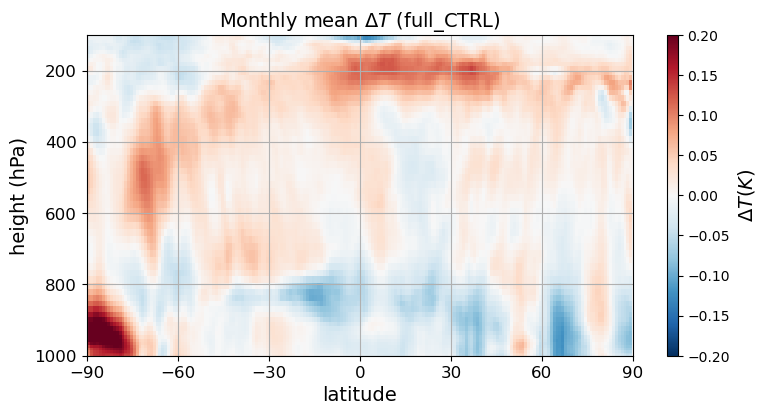

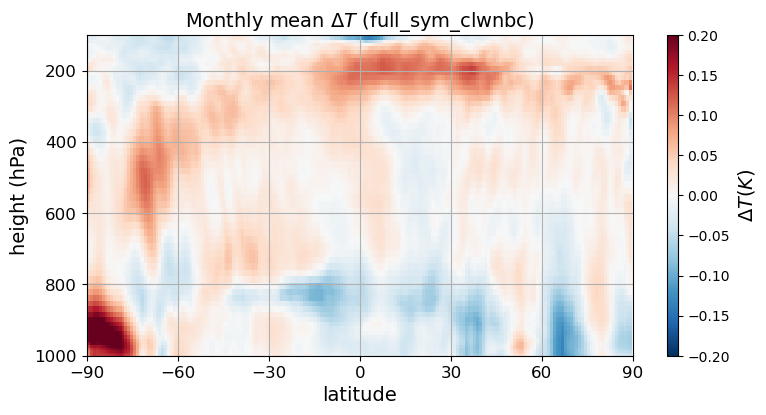

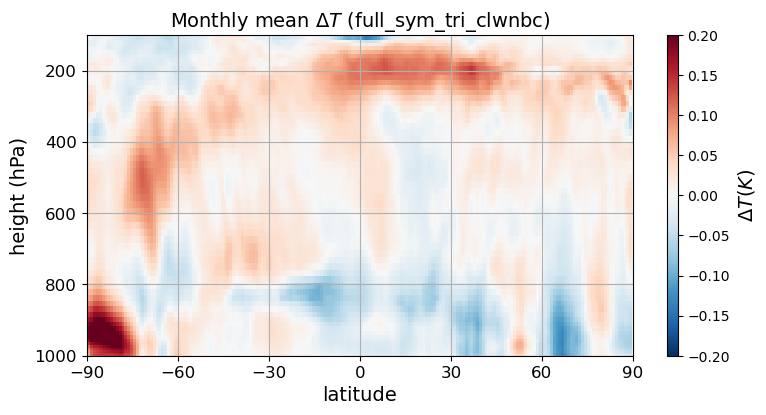

In [9]:
# plot the monthly mean, zonal mean increment for T for DA experiments in exp_list:

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

zonal_mean_vars = {};
pltvars = 'T'

for exp in expids:
    zonal_mean_vars[exp] = np.mean(T[exp],axis=2)
    
lats, levs = np.meshgrid(lat, pfull)

vmin = -0.2
vmax =  0.2
    
exp_list = expids

for exp in exp_list:
    fig, ax = plt.subplots(figsize=(8,4))
    contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_ylim(1000,100)
    ax.set_xlabel('latitude',fontsize=14)
    ax.set_xticks([-90,-60,-30,0,30,60,90])
    ax.set_ylabel('height (hPa)',fontsize=14)
    ax.set_yticks([1000,800,600,400,200])
    ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
    ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
    ax.grid(True)
    plt.tight_layout()

    cbar = fig.colorbar(contour1,location='right',aspect=30)
    #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
    #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels

    cbar.set_label('$\Delta T (K)$', fontsize=14)
    ax.set_title(f'Monthly mean $\Delta T$ ({exp})',fontsize=14)
    if savefig:
        plt.savefig(f'{savefig_dir}/T_inc_monthly_avg_{exp}.png', dpi=200, bbox_inches='tight')

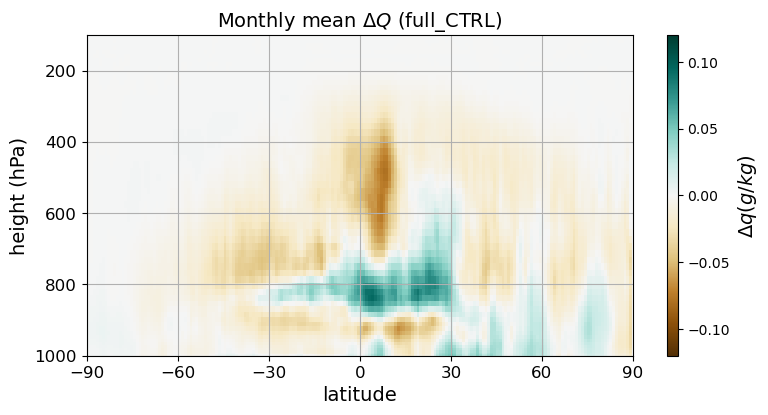

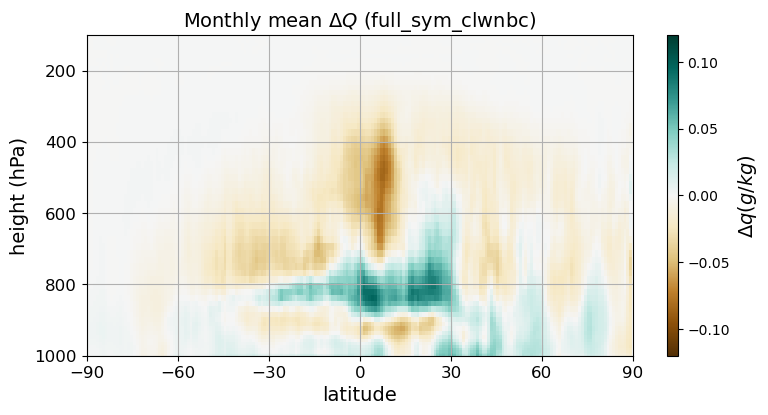

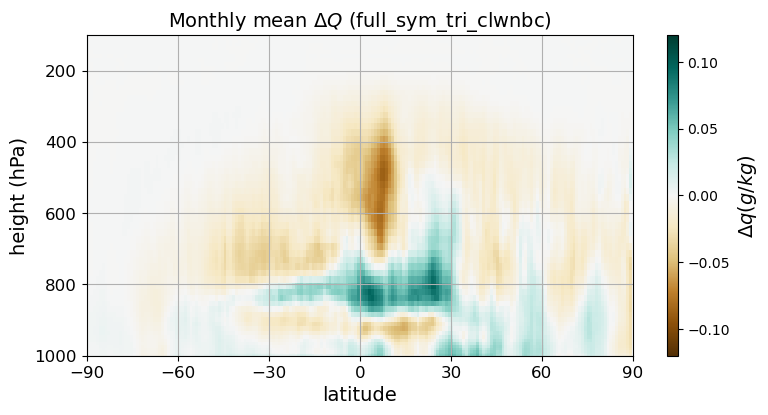

In [10]:
# plot the monthly mean, zonal mean increment for Q for DA experiments in exp_list:

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

zonal_mean_vars = {};

for exp in expids:
    zonal_mean_vars[exp] = np.mean(HUM[exp],axis=2)*1e3
    
lats, levs = np.meshgrid(lat, pfull)

vmin = -0.12
vmax =  0.12
    
exp_list = expids

for exp in exp_list:
    fig, ax = plt.subplots(figsize=(8,4))
    contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp], cmap='BrBG', vmin=vmin, vmax=vmax)
    ax.set_ylim(1000,100)
    ax.set_xlabel('latitude',fontsize=14)
    ax.set_xticks([-90,-60,-30,0,30,60,90])
    ax.set_ylabel('height (hPa)',fontsize=14)
    ax.set_yticks([1000,800,600,400,200])
    ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
    ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
    ax.grid(True)
    plt.tight_layout()

    cbar = fig.colorbar(contour1,location='right',aspect=30)
    #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
    #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels

    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
    ax.set_title(f'Monthly mean $\Delta Q$ ({exp})',fontsize=14)
    if savefig:
        plt.savefig(f'{savefig_dir}/Q_inc_monthly_avg_{exp}.png', dpi=200, bbox_inches='tight')

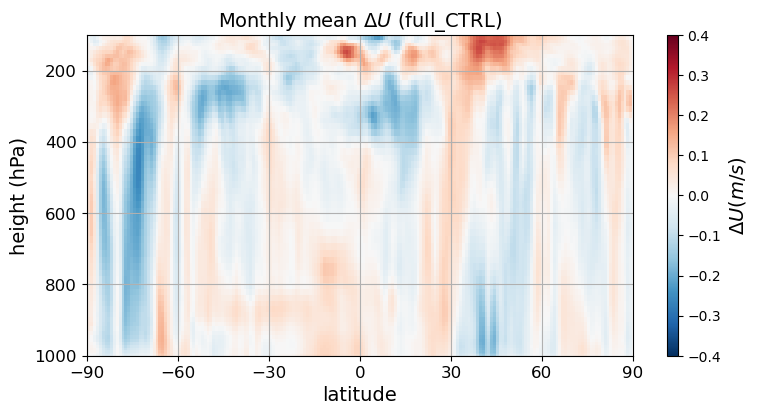

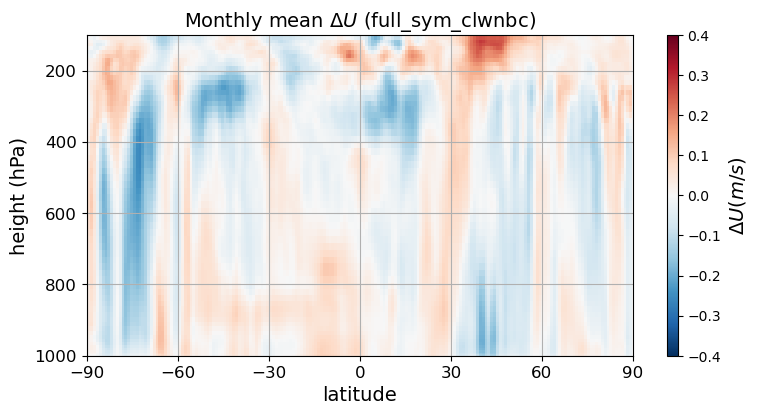

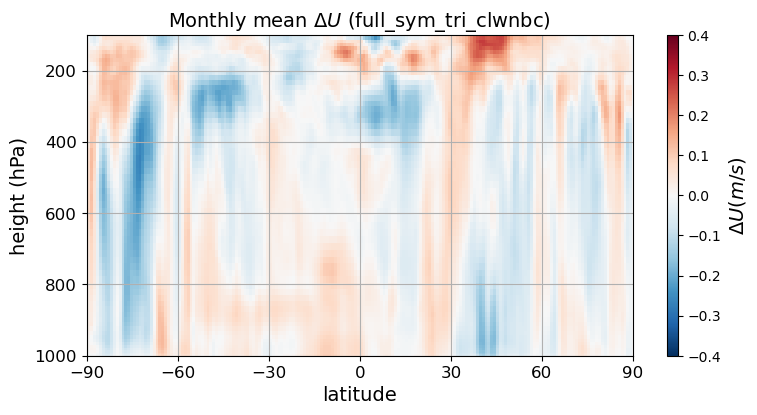

In [11]:
# plot the monthly mean, zonal mean increment for U for DA experiments in exp_list:

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

zonal_mean_vars = {};
pltvars = 'U'

for exp in expids:
    zonal_mean_vars[exp] = np.mean( U[exp], axis=2 )
    
lats, levs = np.meshgrid(lat, pfull)

vmin = -0.4
vmax =  0.4
    
exp_list = expids

for exp in exp_list:
    fig, ax = plt.subplots(figsize=(8,4))
    contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_ylim(1000,100)
    ax.set_xlabel('latitude',fontsize=14)
    ax.set_xticks([-90,-60,-30,0,30,60,90])
    ax.set_ylabel('height (hPa)',fontsize=14)
    ax.set_yticks([1000,800,600,400,200])
    ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
    ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
    ax.grid(True)
    plt.tight_layout()

    cbar = fig.colorbar(contour1,location='right',aspect=30)
    #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
    #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels

    cbar.set_label('$\Delta U (m/s)$', fontsize=14)
    ax.set_title(f'Monthly mean $\Delta U$ ({exp})',fontsize=14)
    if savefig:
        plt.savefig(f'{savefig_dir}/U_inc_monthly_avg_{exp}.png', dpi=200, bbox_inches='tight')
    plt.show()

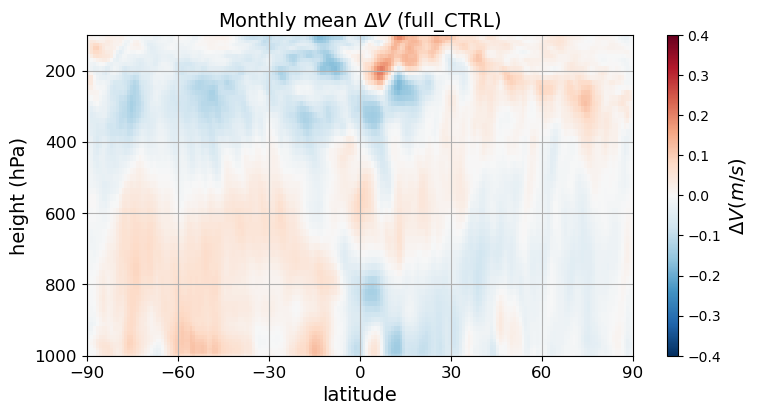

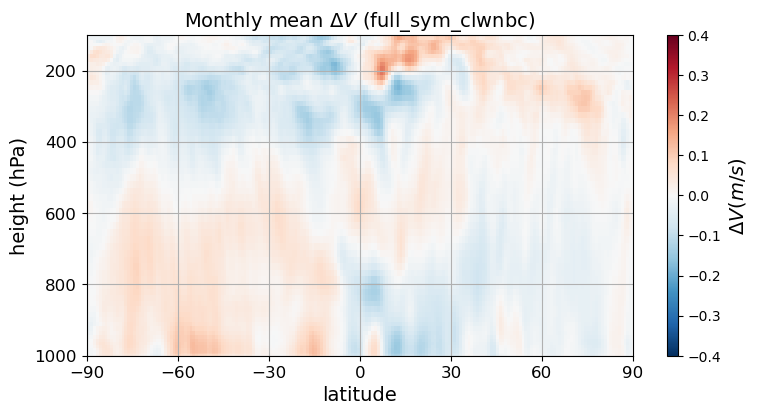

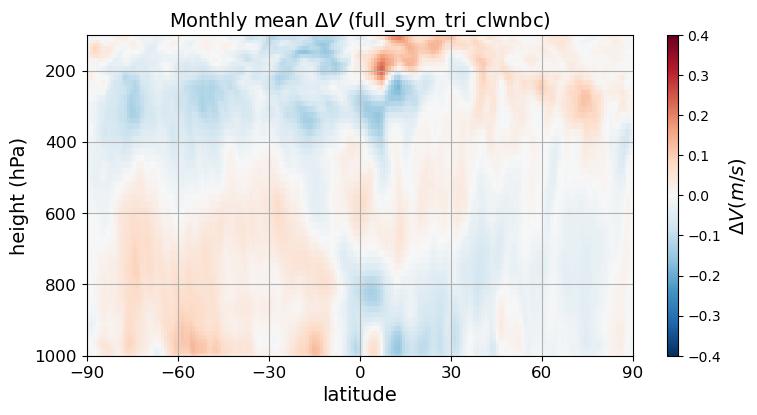

In [12]:
# plot the monthly mean, zonal mean increment for V for DA experiments in exp_list:

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

zonal_mean_vars = {};
pltvars = 'V'

for exp in expids:
    zonal_mean_vars[exp] = np.mean( V[exp], axis=2 )
    
lats, levs = np.meshgrid(lat, pfull)

vmin = -0.4
vmax =  0.4
    
exp_list = expids

for exp in exp_list:
    fig, ax = plt.subplots(figsize=(8,4))
    contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_ylim(1000,100)
    ax.set_xlabel('latitude',fontsize=14)
    ax.set_xticks([-90,-60,-30,0,30,60,90])
    ax.set_ylabel('height (hPa)',fontsize=14)
    ax.set_yticks([1000,800,600,400,200])
    ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
    ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
    ax.grid(True)
    plt.tight_layout()

    cbar = fig.colorbar(contour1,location='right',aspect=30)
    #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
    #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels

    cbar.set_label('$\Delta V (m/s)$', fontsize=14)
    ax.set_title(f'Monthly mean $\Delta V$ ({exp})',fontsize=14)
    if savefig:
        plt.savefig(f'{savefig_dir}/V_inc_monthly_avg_{exp}.png', dpi=200, bbox_inches='tight')
    plt.show()

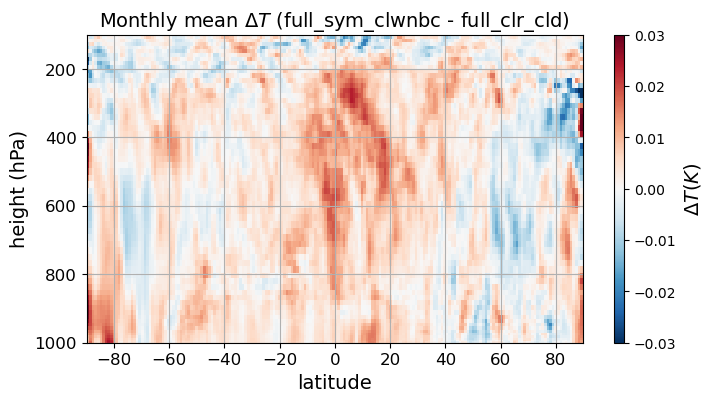

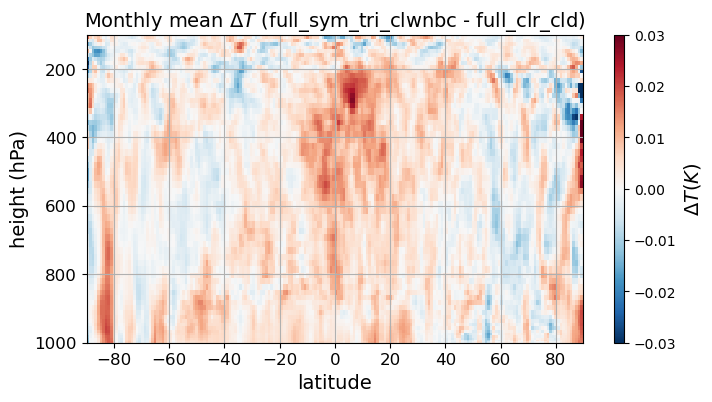

In [24]:
### T difference between experiments

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

'''
expref = 'ctrl'
exp_list = expids
'''

#expref = 'full_CTRL'
expref = expids[0]
#exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']
exp_list = [exp for exp in expids if exp!= expref]

zonal_mean_vars = {};

for exp in exp_list + [expref]:
    zonal_mean_vars[exp] = np.mean(T[exp],axis=2)
    
vmin = -0.03
vmax =  0.03

for exp in exp_list:
    if exp != expref:
        fig, ax = plt.subplots(figsize=(8,4))
        contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp]-zonal_mean_vars[expref], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_ylim(1000,100)
        ax.set_xlabel('latitude',fontsize=14)
        ax.set_ylabel('height (hPa)',fontsize=14)
        ax.set_yticks([1000,800,600,400,200])
        ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
        ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
        ax.grid(True)

        cbar = fig.colorbar(contour1,location='right',aspect=30)
        #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
        #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels
        #cbar.set_label('$\Delta T(K)$', fontsize=14)

        cbar.set_label('$\Delta T (K)$', fontsize=14)
        ax.set_title(f'Monthly mean $\Delta T $ ({exp} - {expref})',fontsize=14)
        
        if savefig:
            plt.savefig(f'{savefig_dir}/T_inc_diff_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')


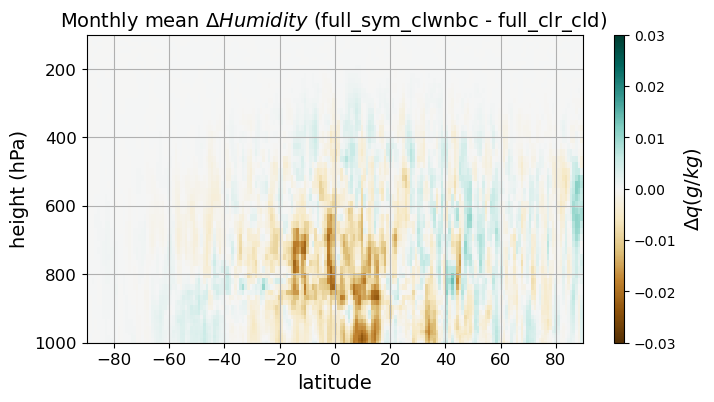

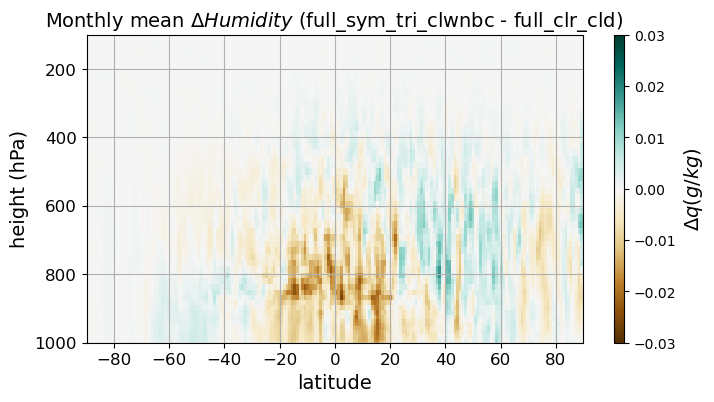

In [25]:
### Q difference between experiments

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

'''
expref = 'ctrl'
exp_list = expids
'''

#expref = 'full_CTRL'
expref = expids[0]
#exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']
exp_list = [exp for exp in expids if exp!= expref]

zonal_mean_vars = {};

for exp in exp_list + [expref]:
    zonal_mean_vars[exp] = np.mean(HUM[exp],axis=2)*1e3

vmin = -0.03
vmax =  0.03

for exp in exp_list:
    if exp != expref:
        fig, ax = plt.subplots(figsize=(8,4))
        contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp]-zonal_mean_vars[expref], cmap='BrBG', vmin=vmin, vmax=vmax)
        ax.set_ylim(1000,100)
        ax.set_xlabel('latitude',fontsize=14)
        ax.set_ylabel('height (hPa)',fontsize=14)
        ax.set_yticks([1000,800,600,400,200])
        ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
        ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
        ax.grid(True)

        cbar = fig.colorbar(contour1,location='right',aspect=30)
        #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
        #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels
        #cbar.set_label('$\Delta T(K)$', fontsize=14)

        cbar.set_label('$\Delta q (g/kg)$', fontsize=14)    
        ax.set_title(f'Monthly mean $\Delta Humidity $ ({exp} - {expref}) ',fontsize=14)
        if savefig:
            plt.savefig(f'{savefig_dir}/Q_inc_diff_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')


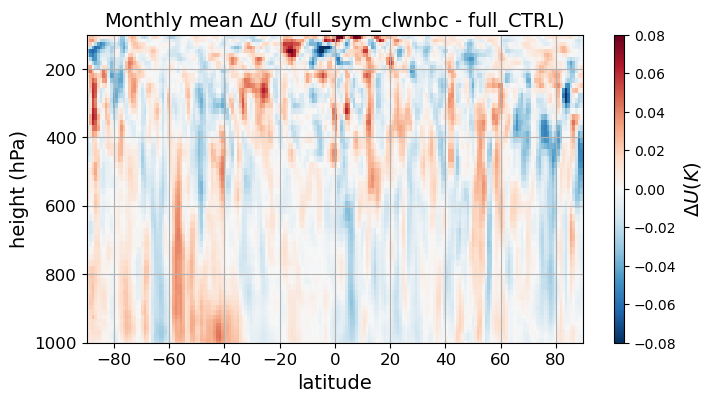

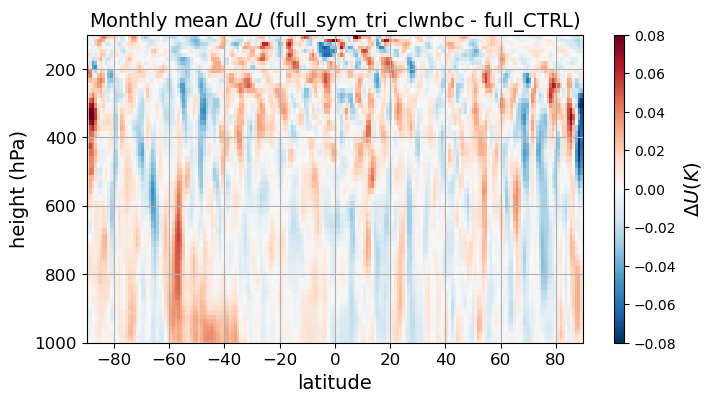

In [17]:
### U difference between experiments

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

'''
expref = 'ctrl'
exp_list = expids
'''

expref = 'full_CTRL'
#exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']
exp_list = [exp for exp in expids if exp!= expref]

zonal_mean_vars = {};

for exp in exp_list + [expref]:
    zonal_mean_vars[exp] = np.mean(U[exp],axis=2)
    
vmin = -0.08
vmax =  0.08

for exp in exp_list:
    if exp != expref:
        fig, ax = plt.subplots(figsize=(8,4))
        contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp]-zonal_mean_vars[expref], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_ylim(1000,100)
        ax.set_xlabel('latitude',fontsize=14)
        ax.set_ylabel('height (hPa)',fontsize=14)
        ax.set_yticks([1000,800,600,400,200])
        ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
        ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
        ax.grid(True)

        cbar = fig.colorbar(contour1,location='right',aspect=30)
        #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
        #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels
        #cbar.set_label('$\Delta T(K)$', fontsize=14)

        cbar.set_label('$\Delta U (K)$', fontsize=14)
        ax.set_title(f'Monthly mean $\Delta U $ ({exp} - {expref})',fontsize=14)
        if savefig:
            plt.savefig(f'{savefig_dir}/U_inc_diff_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')

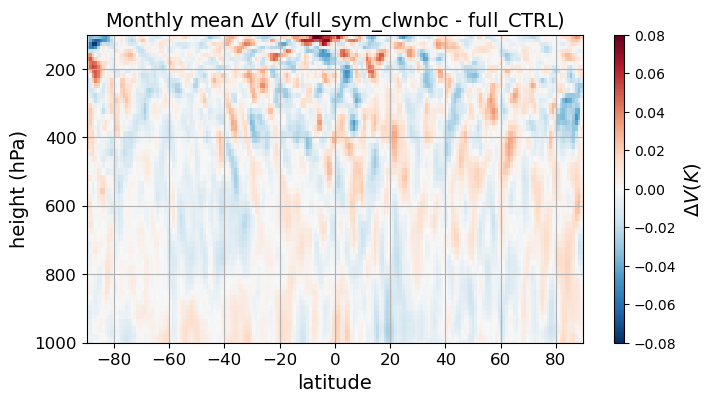

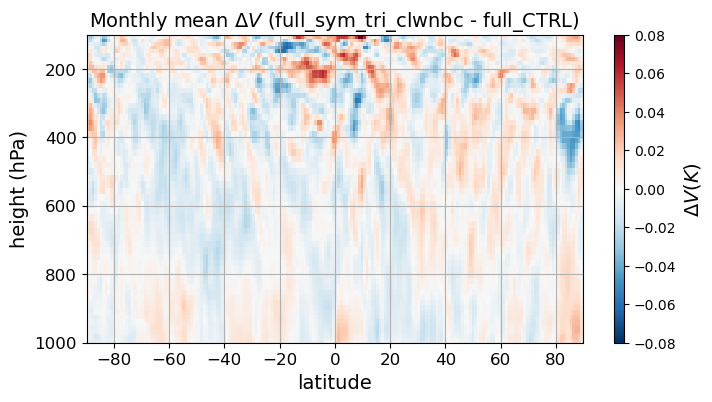

In [18]:
### V difference between experiments

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/lat_height/'
savefig = True

'''
expref = 'ctrl'
exp_list = expids
'''

expref = 'full_CTRL'
#exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']
exp_list = [exp for exp in expids if exp!= expref]

zonal_mean_vars = {};

for exp in exp_list + [expref]:
    zonal_mean_vars[exp] = np.mean(V[exp],axis=2)
    
vmin = -0.08
vmax =  0.08

for exp in exp_list:
    if exp != expref:
        fig, ax = plt.subplots(figsize=(8,4))
        contour1=ax.pcolormesh(lats, levs, zonal_mean_vars[exp]-zonal_mean_vars[expref], cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_ylim(1000,100)
        ax.set_xlabel('latitude',fontsize=14)
        ax.set_ylabel('height (hPa)',fontsize=14)
        ax.set_yticks([1000,800,600,400,200])
        ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
        ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
        ax.grid(True)

        cbar = fig.colorbar(contour1,location='right',aspect=30)
        #cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
        #cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels
        #cbar.set_label('$\Delta T(K)$', fontsize=14)

        cbar.set_label('$\Delta V (K)$', fontsize=14)
        ax.set_title(f'Monthly mean $\Delta V $ ({exp} - {expref})',fontsize=14)
        
        if savefig:
            plt.savefig(f'{savefig_dir}/V_inc_diff_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')

In [ ]:
# Lat-lon plot for 2D map for selected levels (Humidity):

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/2D_map/'
savefig = True

# define levels
pfull = np.array([ 0.6608309, 1.378903, 2.252838, 3.225348, 4.255341, \
                    5.330372, 6.456353, 7.655193, 8.959935, 10.41395, \
                    12.05274, 13.89211, 15.94824, 18.23763, 20.77700, \
                    23.58316, 26.67296, 30.06311, 33.77012, 37.81014, \
                    42.19892, 46.95163, 52.08276, 57.60604, 63.53439, \
                    69.87972, 76.65289, 83.86366, 91.52061, 99.63107, \
                    108.2011, 117.2354, 126.7373, 136.7088, 147.1505, \
                    158.0616, 169.4399, 181.2818, 193.5825, 206.3358, \
                    219.5342, 233.1691, 247.2307, 261.7080, 276.5892, \
                    291.8613, 307.5107, 323.5227, 339.8820, 356.5724, \
                    373.5775, 390.8800, 408.4624, 426.3068, 444.3951, \
                    462.7087, 481.2289, 499.9370, 518.8147, 537.8431, \
                    557.0037, 576.2781, 595.6483, 615.0961, 634.6042, \
                    654.1553, 673.6653, 693.0355, 712.2211, 731.1763, \
                    749.8550, 768.2110, 786.1975, 803.7682, 820.8767, \
                    837.4772, 853.5246, 868.9745, 883.7838, 897.9103, \
                    911.3136, 923.9548, 935.7968, 946.8046, 956.9453, \
                    966.1885, 974.5061, 981.8727, 988.2660, 993.6661, \
                    998.0573]) ;

vertical_slice_avg = [76,79,84,90]
num_vert_level = len(vertical_slice_avg)-1
vert_level_labels = ['850-900 hPa', '900-950 hPa','950-1000 hPa']
vert_level_fn = ['850-900hpa','900-950hpa','950-1000hpa']


expref = 'full_CTRL'
exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']



for i in range(num_vert_level):
    
    i_start = vertical_slice_avg[i]
    i_end   = vertical_slice_avg[i+1]
    
    # expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # first plot the monthly increment of the reference:
    ax.coastlines()
    plt_vars = np.mean(HUM[expref][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='BrBG', vmax=0.3, vmin=-0.3)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Humidity $ ({expref}) (06/15-08/10) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_HUM_inc_{expref}.png', dpi=200, bbox_inches='tight')
        
    
    # loop over over experiments for exp_list - expref
    
    for exp in exp_list:
        # expids[1] - expids[0]
        fig = plt.figure(figsize=(14,5))

        # define the subplots
        ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1

        # ax1: CTRL
        ax.coastlines()
        plt_vars = np.mean(HUM[exp][i_start:i_end,:,:], axis=0) - np.mean(HUM[expref][i_start:i_end,:,:], axis=0)
        contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='BrBG', vmax=0.12, vmin=-0.12)
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude') 
        ax.set_title(f'Monthly mean $\Delta Humidity $ ({exp}-{expref}) (06/15-08/10) at {vert_level_labels[i]}',fontsize=14)
        gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Hide labels on the top side
        gl.right_labels = False  # Hide labels on the right side

        # set colorbar
        cbar = fig.colorbar(contour1,location='right',aspect=40)
        cbar.set_label('$\Delta q (g/kg)$', fontsize=14)

        if savefig:
            plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_HUM_inc_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')

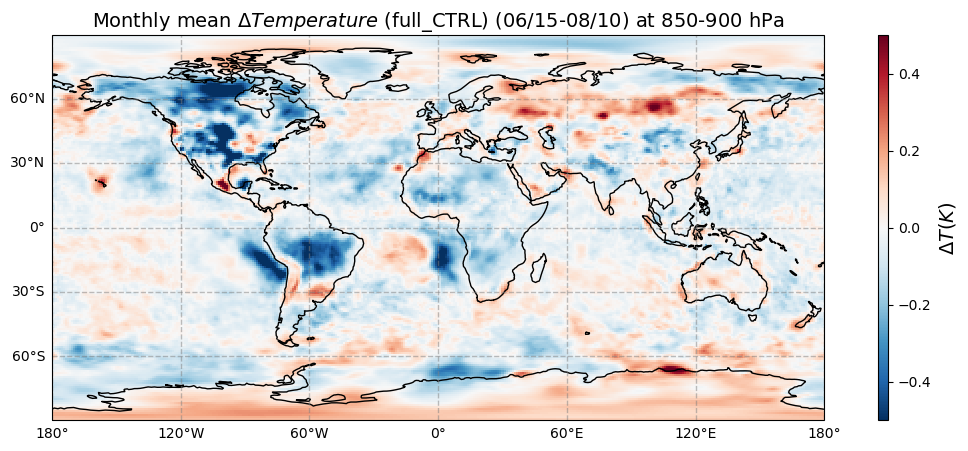

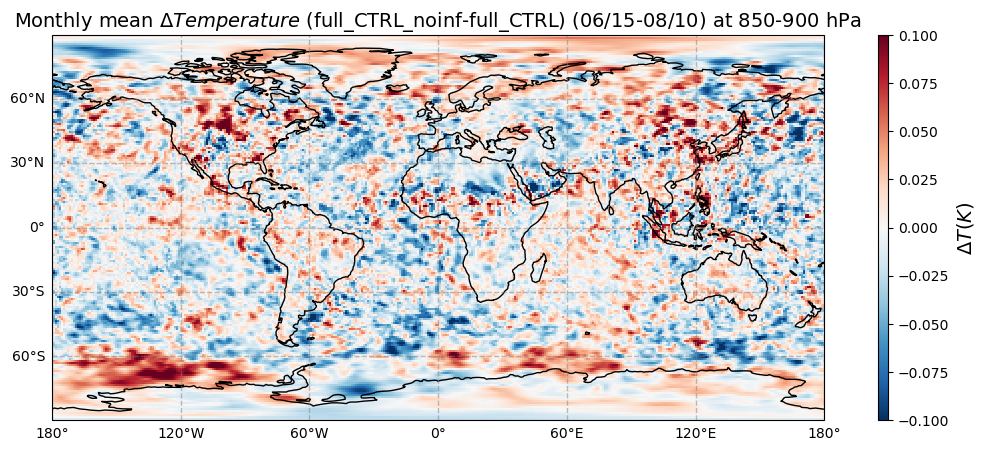

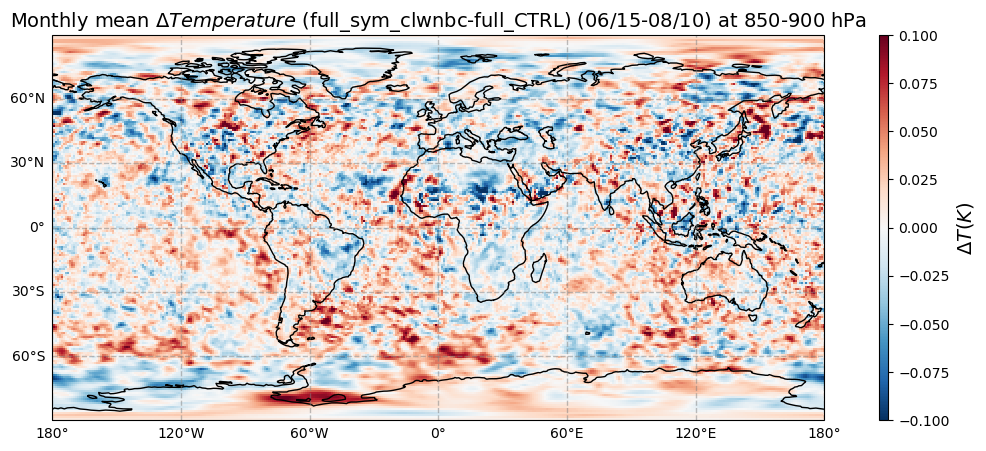

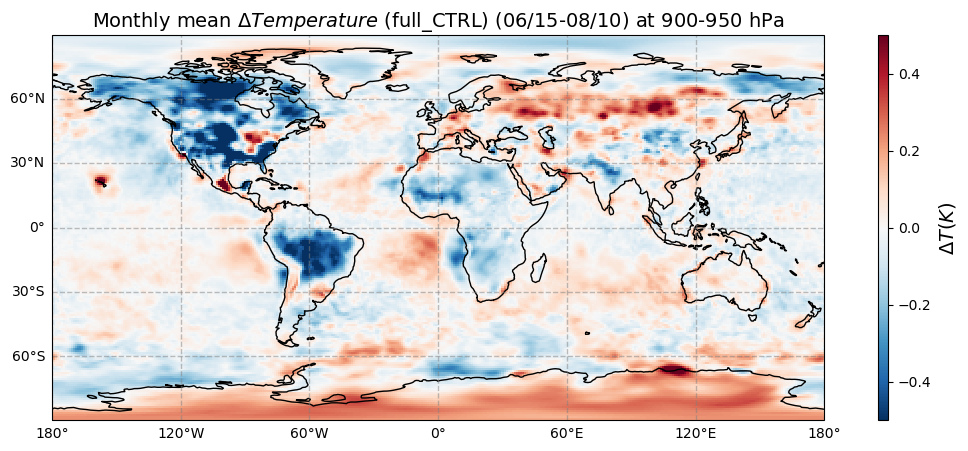

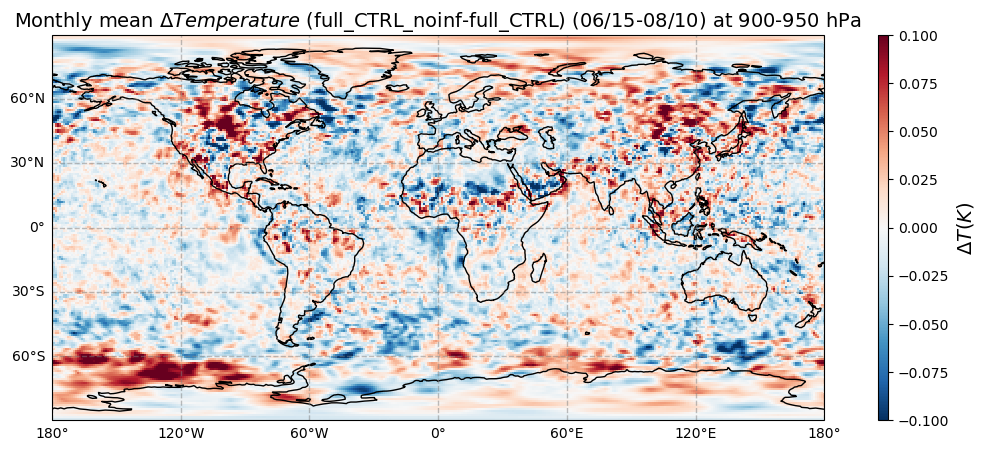

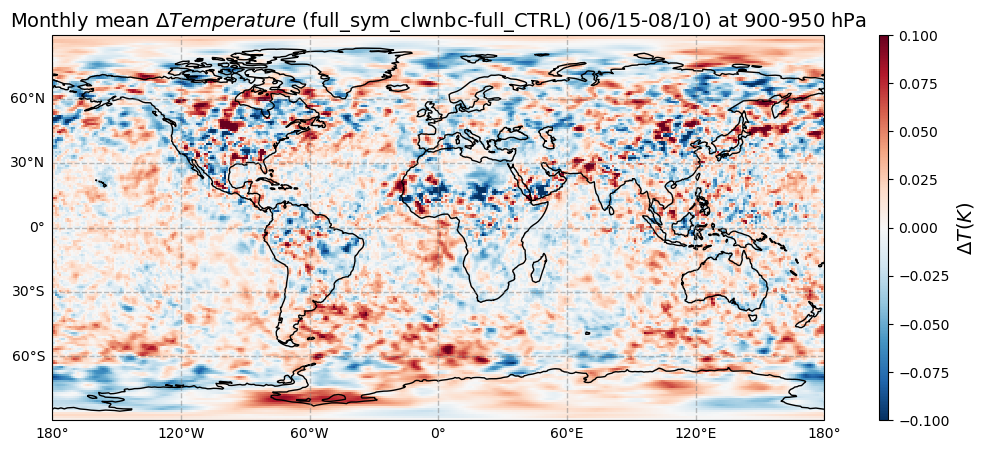

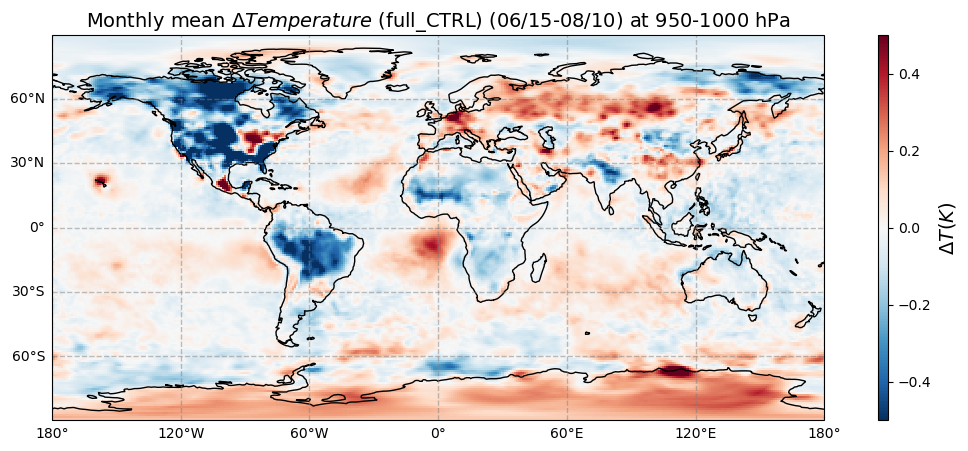

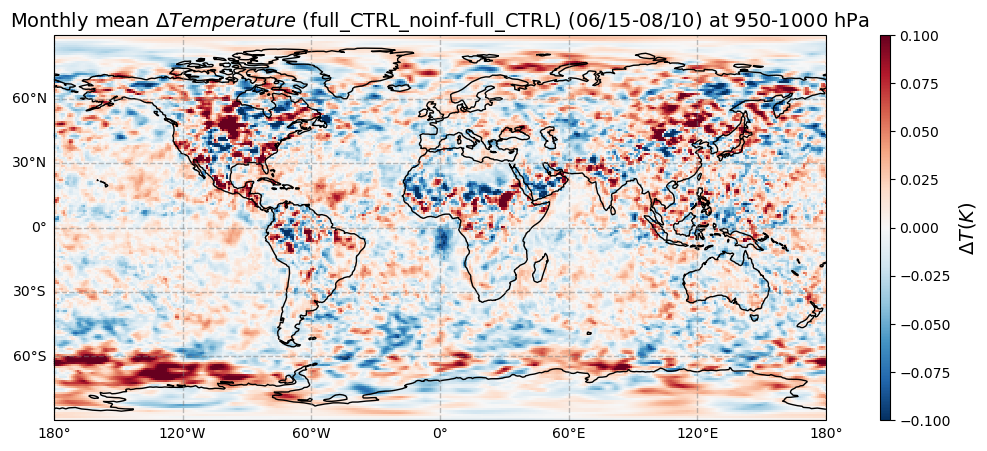

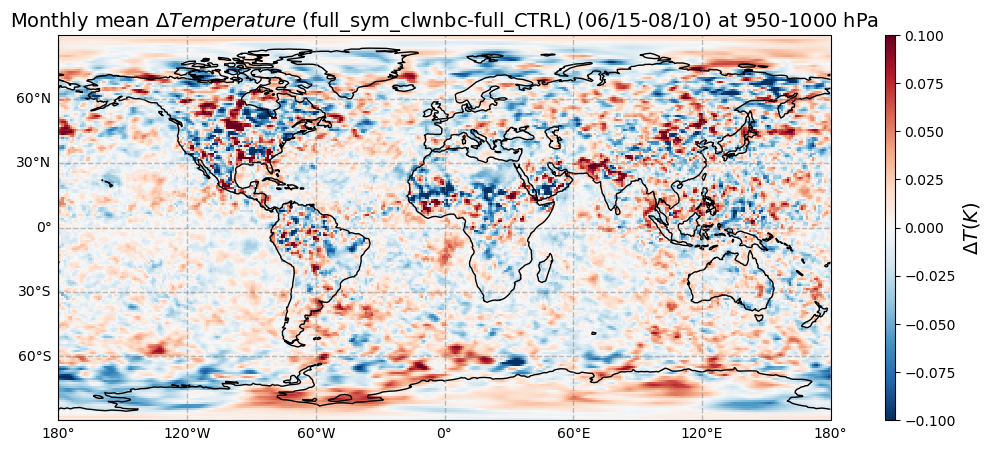

In [26]:
# Lat-lon plot for 2D map for selected levels (Temperature):

savefig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/state_space_compare/analysis_increment/full_cycled_mode/2D_map/'
savefig = True

# define levels
pfull = np.array([ 0.6608309, 1.378903, 2.252838, 3.225348, 4.255341, \
                    5.330372, 6.456353, 7.655193, 8.959935, 10.41395, \
                    12.05274, 13.89211, 15.94824, 18.23763, 20.77700, \
                    23.58316, 26.67296, 30.06311, 33.77012, 37.81014, \
                    42.19892, 46.95163, 52.08276, 57.60604, 63.53439, \
                    69.87972, 76.65289, 83.86366, 91.52061, 99.63107, \
                    108.2011, 117.2354, 126.7373, 136.7088, 147.1505, \
                    158.0616, 169.4399, 181.2818, 193.5825, 206.3358, \
                    219.5342, 233.1691, 247.2307, 261.7080, 276.5892, \
                    291.8613, 307.5107, 323.5227, 339.8820, 356.5724, \
                    373.5775, 390.8800, 408.4624, 426.3068, 444.3951, \
                    462.7087, 481.2289, 499.9370, 518.8147, 537.8431, \
                    557.0037, 576.2781, 595.6483, 615.0961, 634.6042, \
                    654.1553, 673.6653, 693.0355, 712.2211, 731.1763, \
                    749.8550, 768.2110, 786.1975, 803.7682, 820.8767, \
                    837.4772, 853.5246, 868.9745, 883.7838, 897.9103, \
                    911.3136, 923.9548, 935.7968, 946.8046, 956.9453, \
                    966.1885, 974.5061, 981.8727, 988.2660, 993.6661, \
                    998.0573]) ;

vertical_slice_avg = [76,79,84,90]
num_vert_level = len(vertical_slice_avg)-1
vert_level_labels = ['850-900 hPa', '900-950 hPa','950-1000 hPa']
vert_level_fn = ['850-900hpa','900-950hpa','950-1000hpa']



expref = 'full_CTRL'
exp_list = ['full_CTRL_noinf', 'full_sym_clwnbc']


savefig = True

for i in range(num_vert_level):
    
    i_start = vertical_slice_avg[i]
    i_end   = vertical_slice_avg[i+1]
    
    # expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # first plot the monthly increment of the reference:
    ax.coastlines()
    plt_vars = np.mean(T[expref][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars, cmap='RdBu_r', vmax=0.5, vmin=-0.5)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Temperature $ ({expref}) (06/15-08/10) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta T (K)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_T_inc_{expref}.png', dpi=200, bbox_inches='tight')
        
    
    # loop over over experiments for exp_list - expref
    
    for exp in exp_list:
        # expids[1] - expids[0]
        fig = plt.figure(figsize=(14,5))

        # define the subplots
        ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1

        # ax1: CTRL
        ax.coastlines()
        plt_vars = np.mean(T[exp][i_start:i_end,:,:], axis=0) - np.mean(T[expref][i_start:i_end,:,:], axis=0)
        contour1 = ax.pcolormesh(lon, lat, plt_vars, cmap='RdBu_r', vmax=0.1, vmin=-0.1)
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude') 
        ax.set_title(f'Monthly mean $\Delta Temperature $ ({exp}-{expref}) (06/15-08/10) at {vert_level_labels[i]}',fontsize=14)
        gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Hide labels on the top side
        gl.right_labels = False  # Hide labels on the right side

        # set colorbar
        cbar = fig.colorbar(contour1,location='right',aspect=40)
        cbar.set_label('$\Delta T (K)$', fontsize=14)

        if savefig:
            plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_T_inc_{exp}_minus_{expref}.png', dpi=200, bbox_inches='tight')

In [ ]:
# PLOT 2D-MAP of vertically-averaged level (Humidity):
savefig = False

for i in range(num_vert_level):
    
    i_start = vertical_slice_avg[i]
    i_end   = vertical_slice_avg[i+1]
    
    # expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(HUM[expids[0]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='RdBu_r', vmax=0.3, vmin=-0.3)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Humidity $ ({expids[0]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_HUM_inc_{expids[0]}.png', dpi=200, bbox_inches='tight')
        
    
    # expids[1]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(HUM[expids[1]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='RdBu_r', vmax=0.3, vmin=-0.3)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Humidity $ ({expids[1]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_HUM_inc_{expids[1]}.png', dpi=200, bbox_inches='tight')
        
        
        
    # expids[1] - expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(HUM[expids[1]][i_start:i_end,:,:], axis=0) - np.mean(HUM[expids[0]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='RdBu_r', vmax=0.12, vmin=-0.12)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Humidity $ ({expids[1]}-{expids[0]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_HUM_inc_{expids[1]}_minus_{expids[0]}.png', dpi=200, bbox_inches='tight')



In [ ]:
# Lat-lon plot for vertically-averaged level (Temperature):

savefig = False

for i in range(num_vert_level):
    
    i_start = vertical_slice_avg[i]
    i_end   = vertical_slice_avg[i+1]
    
    # expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(T[expids[0]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars, cmap='RdBu_r', vmax=0.6, vmin=-0.6)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta T $ ({expids[0]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta T(K)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_T_inc_{expids[0]}.png', dpi=200, bbox_inches='tight')
        
    
    # expids[1]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(T[expids[1]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars, cmap='RdBu_r', vmax=0.6, vmin=-0.6)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta T $ ({expids[1]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta T(K)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_T_inc_{expids[1]}.png', dpi=200, bbox_inches='tight')
        
        
        
    # expids[1] - expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(T[expids[1]][i_start:i_end,:,:], axis=0) - np.mean(T[expids[0]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars, cmap='RdBu_r', vmax=0.10, vmin=-0.10)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta T $ ({expids[1]}-{expids[0]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta T(K)$', fontsize=14)
    
    if savefig:
        plt.savefig(f'{savefig_dir}monthly_avg_{vert_level_fn[i]}_T_inc_{expids[1]}_minus_{expids[0]}.png', dpi=200, bbox_inches='tight')
        



In [ ]:
np.max(LW['CTRL_no_situ'][:,:,:])

In [ ]:
for i in range(num_vert_level):
    
    i_start = vertical_slice_avg[i]
    i_end   = vertical_slice_avg[i+1]
    
    # expids[0]
    fig = plt.figure(figsize=(14,5))

    # define the subplots
    ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1
    
    # ax1: CTRL
    ax.coastlines()
    plt_vars = np.mean(ICMR[expids[0]][i_start:i_end,:,:], axis=0)
    contour1 = ax.pcolormesh(lon, lat, plt_vars*1e3, cmap='RdBu_r')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    ax.set_title(f'Monthly mean $\Delta Humidity $ ({expids[0]}) (06/20-07/20) at {vert_level_labels[i]}',fontsize=14)
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Hide labels on the top side
    gl.right_labels = False  # Hide labels on the right side

    # set colorbar
    cbar = fig.colorbar(contour1,location='right',aspect=40)
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)

In [ ]:
if pltvars == 'T':
    plt_levs = np.linspace(-2,2,21)*1e-1
    plt_vars = T['CTRL_no_situ'][i,:,:] - T['CTRL'][i,:,:]

elif pltvars == 'HUM':
    plt_levs = np.linspace(-2,2,21)*1e-1
    plt_vars = (HUM['CTRL_no_situ'][i,:,:] - HUM['CTRL'][i,:,:])*1e3


fig = plt.figure(figsize=(14,5))

# define the subplots
ax = fig.add_subplot(projection=ccrs.PlateCarree())  # Add subplot at position 1

i=85
# ax1: CTRL bias
ax.coastlines()

contour1 = ax.contourf(lon, lat, plt_vars, cmap='RdBu_r', levels=plt_levs)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude') 
if pltvars == 'T':
    cbar.set_label('$\Delta T(K)$', fontsize=14)
    ax.set_title(f'Temperature increment at {pfull[i]:.2f} hPa')
elif pltvars == 'HUM':
    cbar.set_label('$\Delta q(g/kg)$', fontsize=14)
    ax.set_title(f'Specific humidity increment at {pfull[i]:.2f} hPa')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top side
gl.right_labels = False  # Hide labels on the right side

# set colorbar
cbar = fig.colorbar(contour1,location='right',aspect=40)
#cbar.set_ticks([-6,-4,-2,0,2,4,6])  # Set the tick positions
#cbar.set_ticklabels(['Low', 'Medium', 'Medium-High', 'High', 'Very High'])  # Set the tick labels
